# Overview of univariate distribution management


## Abstract

In this example, we present the following topics: 

- the distributions with several parametrizations (particularly with the `Beta` distribution),
- the arithmetic of distributions and functions of distributions,
- the `CompositeDistribution` for more general functions,
- how to define our customized distibution with `PythonDistribution` if the distribution do not exist.

In [1]:
import openturns as ot

## Distributions with several parametrizations

By default, any univariate distribution uses its native parameters. For some few distributions, alternative parameters might be used to define the distribution. 

For example, the `Beta` distribution has several parametrizations. 

The native parametrization uses the following parameters:

- $\alpha$ : the first shape parameter, $\alpha>0$,
- $\beta$ : the second shape parameter, $\beta> 0$,
- $a$ : the lower bound,
- $b$ : the upper bound with $a<b$.

The PDF of the beta distribution is:

$$
f(x) = \frac{(x-a)^{\alpha - 1} (b - x)^{\beta - 1}}{(b - a)^{\alpha + \beta - 1} B(\alpha, \beta)}
$$

for any $x\in[a,b]$, where $B$ is Euler's beta function. 

For any $y,z>0$, the beta function is:

$$
B(y,z) = \int_0^1 t^{y-1} (1-t)^{z-1} dt.
$$

The `Beta` class uses the native parametrization.

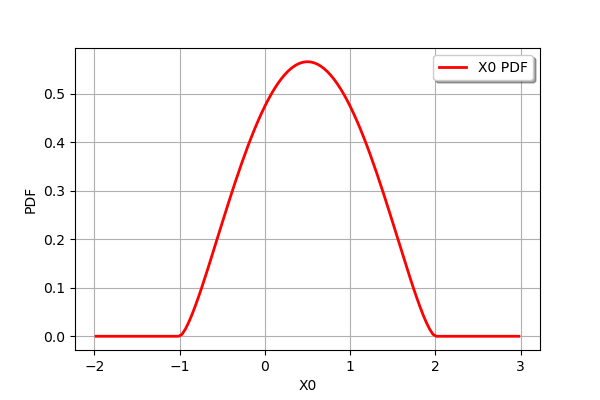

In [2]:
distribution = ot.Beta(2.5, 2.5, -1, 2)
distribution.drawPDF()

The `BetaMuSigma` class provides another parametrization, based on the expectation $\mu$ and the standard deviation  $\sigma$ of the random variable:

$$
\mu = a + \frac{(b-a)\alpha}{\alpha+\beta}
$$

and

$$
\sigma^2 = \left(\frac{b-a}{\alpha+\beta}\right)^2 \frac{\alpha\beta}{\alpha+\beta+1}.
$$

Inverting the equations, we get:


$$
\alpha =  \left(\dfrac{\mu-a}{b-a}\right) \left( \dfrac{(b-\mu)(\mu-a)}{\sigma^2}-1\right) \\
$$

and

$$
\beta  =  \left( \dfrac{b-\mu}{\mu-a}\right) \alpha
$$

The following session creates a beta random variable with parameters $\mu=0.2$, $\sigma=0.6$, $a=-1$ et $b=2$.

In [3]:
parameters = ot.BetaMuSigma(0.2, 0.6, -1, 2)
parameters.evaluate()

class=Point name=Unnamed dimension=4 values=[2,3,-1,2]

The `ParametrizedDistribution` creates a distribution from a parametrization.

In [4]:
param_dist = ot.ParametrizedDistribution(parameters)
param_dist

class=ParametrizedDistribution parameters=class=BetaMuSigma name=Unnamed mu=0.2 sigma=0.6 a=-1 b=2 distribution=class=Beta name=Beta dimension=1 alpha=2 beta=3 a=-1 b=2

## Functions of distributions

The library provides algebra of univariate distributions:

 - +, -
 - *, /

It also provides methods to get the full distributions of `f(x)` where `f` can be equal to :

 - `sin`, 
 - `cos`, 
 - `acos`, 
 - `asin`
 - `square`, 
 - `inverse`, 
 - `sqrt`.

In the following example, we create a beta and an exponential variable. Then we create the random variable equal to the sum of the two previous variables. 

In [5]:
B = ot.Beta(5, 2, 9, 10)

In [6]:
E = ot.Exponential(3)

In [7]:
S = B + E

The `S` variable is equipped with the methods of any distribution: we can for example compute the PDF or the CDF at any point and compute its quantile. For example, we can simply draw the PDF with the `drawPDF` class.

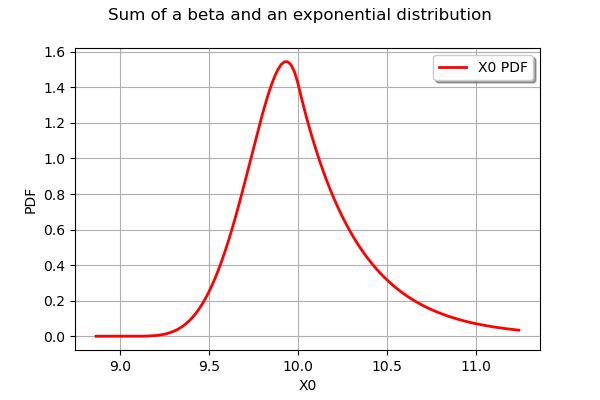

In [8]:
graph = S.drawPDF()
graph.setTitle("Sum of a beta and an exponential distribution")
graph

The exponential function of this distribution can be computed with the `exp` method.

In [9]:
sumexp = S.exp()

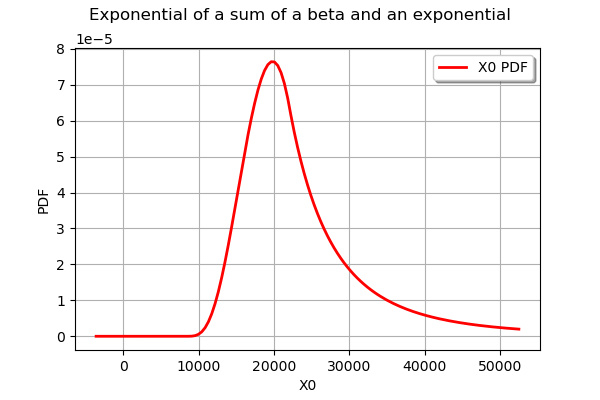

In [10]:
graph = sumexp.drawPDF()
graph.setTitle("Exponential of a sum of a beta and an exponential")
graph

## The `CompositeDistribution` class for more general functions

More complex functions can be created thanks to the `CompositeDistribution` class, but it requires an `f` function. In the following example, we create the distribution of a random variable equal to the exponential of a gaussian variable. Obviously, this is equivalent to the `LogNormal` distribution but this shows how such a distribution could be created.

First, we create a distribution.

In [11]:
N = ot.Normal(0.0, 1.0)
N.setDescription(["Normal"])

Secondly, we create a function. 

In [12]:
f = ot.SymbolicFunction(['x'], ['exp(x)'])
f.setDescription(["X","Exp(X)"])

Finally, we create the distribution equal to the exponential of the gaussian random variable. 

In [13]:
dist = ot.CompositeDistribution(f, N)

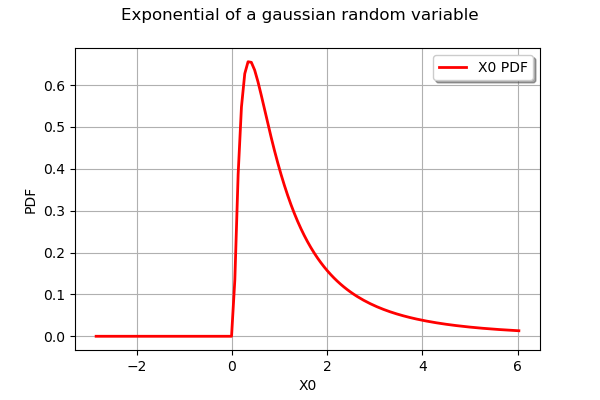

In [14]:
graph = dist.drawPDF()
graph.setTitle("Exponential of a gaussian random variable")
graph

In order to check the previous distribution, we compare it with the LogNormal distribution.

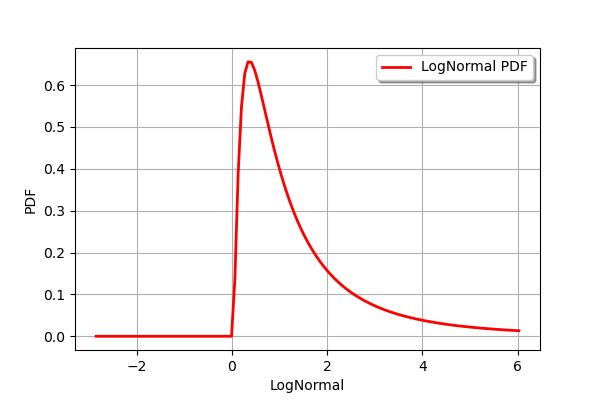

In [15]:
LN = ot.LogNormal()
LN.setDescription(["LogNormal"])
LN.drawPDF()

## The `PythonDistribution` class

Another possibility is to define our own `distribution`. 

For example let us implement the `Quartic` kernel (also known as the `Biweight` kernel, see https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use), which is sometimes used in the context of kernel smoothing. 
The PDF of the kernel is defined by:

$$
f(u) = \frac{15}{16} (1 - u^2)^2
$$

for any $u\in[-1,1]$ and $f(u)=0$ otherwise. 

Expanding the previous square, we find:

$$
f(u) = \frac{15}{16} (1 - 2 u^2 + u^4)
$$

for any $u\in[-1,1]$. 

Integrating the previous equation leads to the CDF:

$$
F(u) = \frac{1}{2} + \frac{15}{16} u - \frac{5}{8} u^3 + \frac{3}{16} u^5
$$

for any $u\in[-1,1]$ and $F(u)=0$ otherwise. 

The only required method is `computeCDF`. Since the PDF is easy to define in our example, we implement it as well. Here, the distribution is defined on the interval $[-1,1]$, so that we define the `getRange` method.

In [16]:
class Quartic(ot.PythonDistribution):
    """
    Quartic (biweight) kernel
    See https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use for more details 
    """
    def __init__(self):
        super(Quartic, self).__init__(1)
        self.c = 15.0 / 16
    
    def computeCDF(self, x):
        u = x[0]
        if u <= -1:
            p = 0.0
        elif u >= 1:
            p = 1.0
        else:
            p = 0.5 + 15./16 * u - 5. / 8 * pow(u,3) + 3./16 * pow(u,5)
        return p

    def computePDF(self, x):
        u = x[0]
        if u < -1 or u > 1:
            y = 0.0
        else:
            y = self.c * (1 - u **2)**2
        return y

    def getRange(self):
        return ot.Interval(-1, 1)

In [17]:
Q = ot.Distribution(Quartic())
Q.setDescription(["Quartic Kernel"])

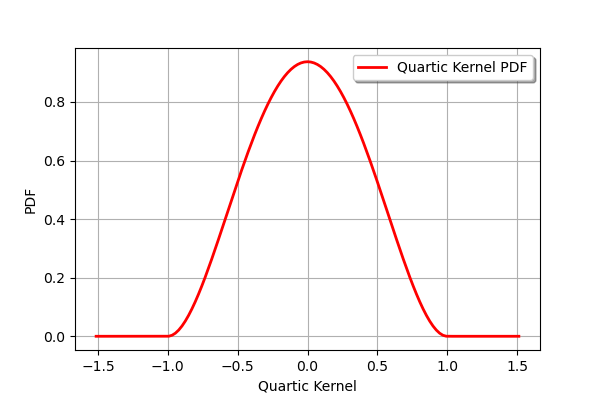

In [18]:
Q.drawPDF()